Kaye Ng and Vivian Uy's submission for Programming Assessment #4

INTRNLP S17

### Importing packages

In [1]:
import pandas as pd
import nltk
import numpy as np
import html
import re
import pickle
import csv

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from symspellpy.symspellpy import SymSpell, Verbosity

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as make_pipeline_imb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

### Defining functions

In [2]:
def defaultPlotting():
    sns.set(rc={'figure.figsize': (12, 6)})
    sns.set_context("talk", rc={"font.size": 20, "axes.titlesize": 18, "axes.labelsize": 18})
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 24
    
defaultPlotting()

In [3]:
def plot_confusion_matrix(y_predict):
    classes = ['negative', 'neutral', 'positive']
    mat = confusion_matrix(y_test, y_predict)
    
    cm_sum = np.sum(mat, axis=1, keepdims=True)
    cm_perc = mat / cm_sum.astype(float) * 100
    
    annot = np.empty_like(mat).astype(str)
    nrows, ncols = mat.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = mat[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(mat, square=True, annot=annot, fmt='', vmax=800,
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 14},
               cmap=sns.cm.rocket_r)
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.yticks(rotation=0)
    plt.title('Confusion matrix')
    
#     plt.savefig('confusion-matrix.png', bbox_inches="tight", dpi=300)
    plt.show()

In [58]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t{:.4f}\t%{: >15s}\t\t{:.4f}\t {: >15s}".format(coef_1, fn_1, coef_2, fn_2))

In [4]:
slang_dict = {}
contractions = {}

def load_dictionary(dictionary, filename):
    with open(filename, "r") as myCSVfile:
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        for row in dataFromFile:
            dictionary[row[0].lower()] = row[1].lower()

        myCSVfile.close()

load_dictionary(slang_dict, "data/slang.txt")
load_dictionary(contractions, "data/contractions.txt")

In [5]:
with open('pos_tag_corpus.pickle', 'rb') as handle:
    pos_set = pickle.load(handle)

In [6]:
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

# term_index = 0  # column of the term in the dictionary text file
# count_index = 1  # column of the term frequency in the dictionary text file

if not sym_spell.load_dictionary("data/frequency_dictionary_en_82_765.txt", 0, 1):
    print("Dictionary file not found")

In [7]:
def get_correct_spelling(word):
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.CLOSEST
    suggestions = sym_spell.lookup(word, suggestion_verbosity,
                                   max_edit_distance_lookup)

    if len(suggestions) > 0:
        return suggestions[0].term
    else:
        return word

In [8]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_text(tweet):
    return [token for token in tokenizer.tokenize(tweet) if len(token) > 2]

In [9]:
pattern = re.compile(r"(\b[-'.]\b)|[\W_]")

def remove_punct(doc):
    return pattern.sub(lambda m: (m.group(1) if m.group(1) else " "), doc)

In [10]:
def reduce_word(word):
    p = re.compile(r"(.)\1{2,}")
    return p.sub(r"\1\1", word)

In [11]:
class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # default pos in lemmatization is noun
            return wordnet.NOUN

In [12]:
def preprocess(word):
    word = get_correct_spelling(word)
    
    if word in pos_set:
        tag = pos_set[word]
    else:
        tag = nltk.pos_tag([word])[0][1]
    
    #filter out non-verbs, non-adjectives and non-adverbs then lemmatize
    if tag.startswith(("V", "J", "R")):
        return WordNetLemmatizer().lemmatize(word.strip().replace(".", ""),
                                      pos=LemmatizationWithPOSTagger().get_wordnet_pos(
                                                        tag))
    
    return ""

In [13]:
class TokenizeTweet(object):
    def __call__(self, doc):
        cleaned = []
        tokenize = tokenize_text(doc)

        for token in tokenize:

            if not token.startswith(('#', 'http://')):
                token = reduce_word(token)
                token = remove_punct(token)

                if token in slang_dict.keys():
    #                     print('slang found:', slang_dict[token])

                    for word in slang_dict[token].split():
                        token = preprocess(word)
                        if token.strip() != "":
                            cleaned.append(token)

                elif token in contractions.keys():
    #                     print('contraction found:', contractions[token])

                    for word in contractions[token].split():
                        token = preprocess(word)
                        if token.strip() != "":
                            cleaned.append(token)

                else:
                    cleaned.append(preprocess(token))

        return [word.strip() for word in cleaned if word != '']

### Reading and inspecting the data

In [14]:
df = pd.read_csv('data/Virgin America and US Airways Tweets.csv', sep='\t')

df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


### Understanding the corpus

In [15]:
df.dtypes

airline_sentiment    object
airline              object
text                 object
dtype: object

In [16]:
df.shape

(3417, 3)

In [17]:
df.describe(include='all')

,airline_sentiment,airline,text
count,3417,3417,3417
unique,3,2,3409
top,negative,US Airways,@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏
freq,2444,2913,3


In [18]:
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [19]:
df.airline_sentiment.value_counts()

negative    2444
neutral     552 
positive    421 
Name: airline_sentiment, dtype: int64

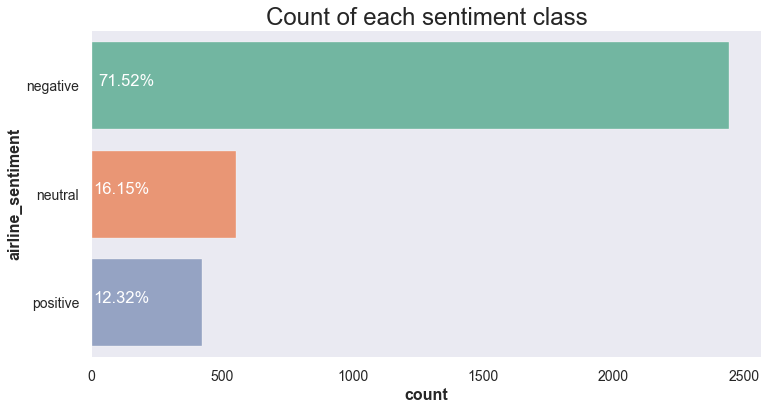

In [20]:
pct = ((df.airline_sentiment.value_counts() / df.airline_sentiment.count()) * 100)

ax = sns.countplot(y="airline_sentiment", data=df, palette="Set2", linewidth=0.3,
                   order = df.airline_sentiment.value_counts().index)

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{0:.2f}%'.format(pct[i]), (p.get_x() + 0.01 * width, p.get_y() + .45 * height), 
                color='white', ha='left', va='center', fontsize='small')

plt.title('Count of each sentiment class', fontsize=24)
plt.grid(False)

In [21]:
# get total words per class

def count_words(nArray):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
    transtab = str.maketrans(dict.fromkeys(punct, ''))

    word_count = 0
    for sentence in nArray:
        tokens = nltk.word_tokenize(sentence.translate(transtab))
        
        # the translate portion just removed the punctuation
        word_count += len(tokens)

    return word_count

print("Total words in negative tweets:", count_words(df.loc[df.airline_sentiment == 'negative'].text.values))

print("Total words in neutral tweets:", count_words(df.loc[df.airline_sentiment == 'neutral'].text.values))

print("Total words in positive tweets:", count_words(df.loc[df.airline_sentiment == 'positive'].text.values))

Total words in negative tweets: 48095
Total words in neutral tweets: 8327
Total words in positive tweets: 5928


### Pre-processing the text

In [22]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

There are some values containing `\n`, so let's remove those.

In [23]:
df['text'] = df['text'].apply(lambda x: x.replace("\n", " "))

In [24]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"

We can see that `\n` was correctly replaced with a space.

In [25]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

There are some symbols that were encoded as HTML character entities, so we need to convert them back to symbols.

In [26]:
df['text'] = df['text'].apply(lambda x: html.unescape(x))

In [27]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

We can see that the `&` character was converted back into symbol form.

**Problem**: how to convert symbols (incl. emoji) into words?

Example:

In [28]:
df.iloc[11].text

'@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D'

<3 --> 'love' ?

**Problem**: typos

Example:

In [29]:
df.iloc[182].text

'@VirginAmerica Flight from BOS > LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?'

**Problem**: slang words

Example:

In [30]:
df.iloc[3414].text

'@USAirways reservations had me on hold for 2 hours only to hang up...smh 😕'

### Splitting into training and testing sets

In [31]:
X = df.text
y = df.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(
    X, # Features
    y, # Labels
    test_size = 0.3, # The defined test size; Training size is just 1 minus the test size
    random_state = 42 # So we can shuffle the elements, but with some consistency
)

print("=====\nTraining Data")
print("Document count: %s" % len(y_train))
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_train)))
        
print("=====\nTesting Data")
print("Document count: %s" % len(y_test))
labels, counts = np.unique(y_test, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_test)))

=====
Training Data
Document count: 2391
negative: 1723 (0.7206)
neutral: 378 (0.1581)
positive: 290 (0.1213)
=====
Testing Data
Document count: 1026
negative: 721 (0.7027)
neutral: 174 (0.1696)
positive: 131 (0.1277)


### Extracting features from text

In [37]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

# vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
#                              max_df=0.9, ngram_range=(1, 3), lowercase=False)

count_vect_df = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), 
                             columns=sorted(vectorizer.vocabulary_.keys()))

count_vect_df.head()

,1874get,1874get late,2hr15min,2hr15min have,2hr15min have estimate,3hr30min,3hr30min right,3hr30min right now,50minss,513mph,...,yet tonnes,yet tonnes explain,yield,yield be,yield be exact,young,young american,young american new,yummy,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
count_vect_df.sum(axis=0)

1874get                   1 
1874get late              1 
2hr15min                  1 
2hr15min have             1 
2hr15min have estimate    1 
3hr30min                  1 
3hr30min right            1 
3hr30min right now        1 
50minss                   1 
513mph                    1 
513mph strong             1 
639p                      1 
639p deliver              1 
able                      15
able able                 1 
able able make            1 
able buy                  1 
able buy speak            1 
able call                 1 
able call tell            1 
able complete             1 
able complete waste       1 
able do                   1 
able do not               1 
able earlier              1 
able entire               1 
able entire hold          1 
able get                  1 
able get reschedule       1 
able locate               1 
                         .. 
yet hate much             1 
yet have                  2 
yet have good             1 
yet have tight

### Training the models

Baseline, no preprocessing, no resampling

Accuracy:  0.7680311890838206 

              precision    recall  f1-score   support

    negative   0.770901  0.984743  0.864799       721
     neutral   0.679245  0.206897  0.317181       174
    positive   0.807692  0.320611  0.459016       131

   micro avg   0.768031  0.768031  0.768031      1026
   macro avg   0.752613  0.504084  0.546999      1026
weighted avg   0.760055  0.768031  0.720118      1026



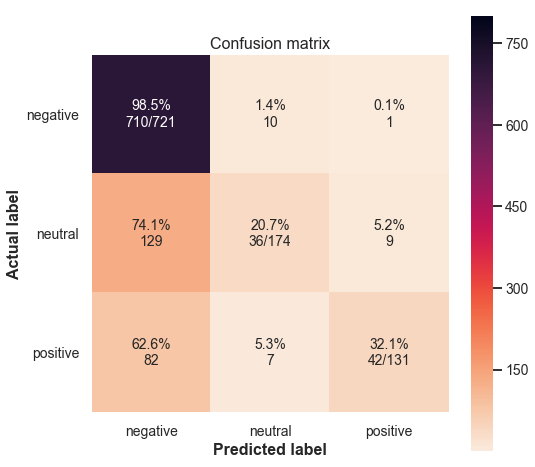

In [64]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

Accuracy:  0.7046783625730995 

              precision    recall  f1-score   support

    negative   0.706575  0.998613  0.827586       721
     neutral   0.428571  0.017241  0.033149       174
    positive   0.000000  0.000000  0.000000       131

   micro avg   0.704678  0.704678  0.704678      1026
   macro avg   0.378382  0.338618  0.286912      1026
weighted avg   0.569213  0.704678  0.587191      1026



/home/kayeval/Documents/ml_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


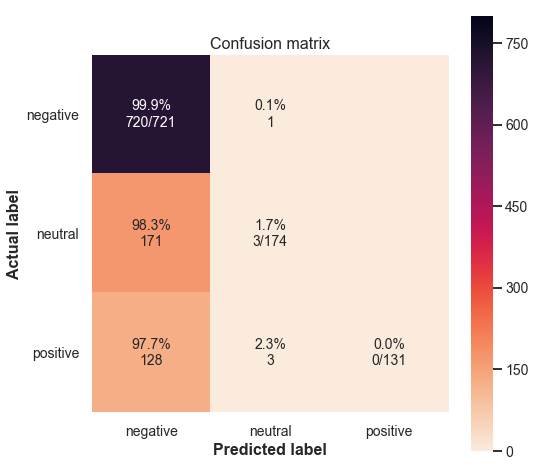

In [45]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

Baseline, with random undersampling

Accuracy:  0.767056530214425 

              precision    recall  f1-score   support

    negative   0.871977  0.850208  0.860955       721
     neutral   0.520270  0.442529  0.478261       174
    positive   0.554286  0.740458  0.633987       131

   micro avg   0.767057  0.767057  0.767057      1026
   macro avg   0.648844  0.677732  0.657734      1026
weighted avg   0.771768  0.767057  0.767074      1026



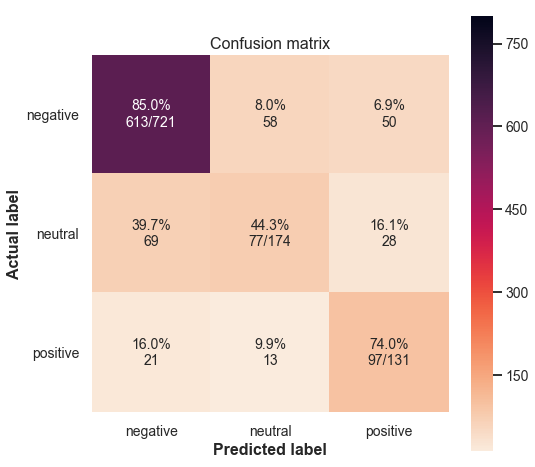

In [47]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

Accuracy:  0.7456140350877193 

              precision    recall  f1-score   support

    negative   0.903537  0.779473  0.836932       721
     neutral   0.470874  0.557471  0.510526       174
    positive   0.535354  0.809160  0.644377       131

   micro avg   0.745614  0.745614  0.745614      1026
   macro avg   0.636588  0.715368  0.663945      1026
weighted avg   0.783152  0.745614  0.756991      1026



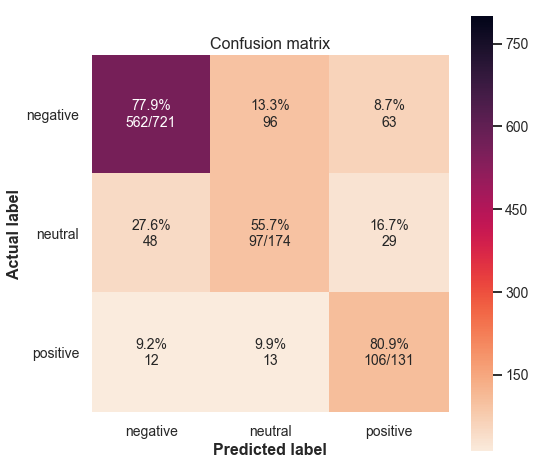

In [62]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

Baseline, with near-miss undersampling

Accuracy:  0.52046783625731 

              precision    recall  f1-score   support

    negative   0.941176  0.443828  0.603205       721
     neutral   0.363971  0.568966  0.443946       174
    positive   0.277778  0.877863  0.422018       131

   micro avg   0.520468  0.520468  0.520468      1026
   macro avg   0.527642  0.630219  0.489723      1026
weighted avg   0.758585  0.520468  0.553062      1026



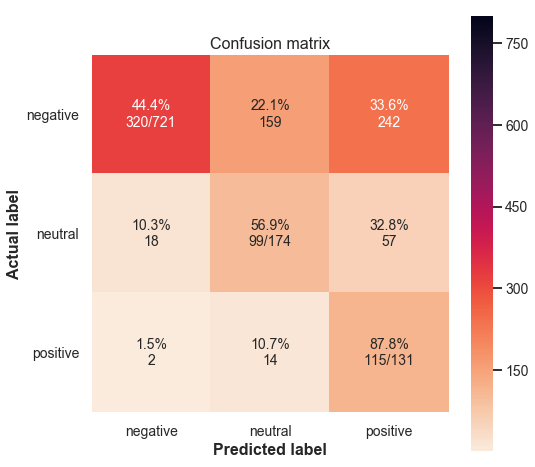

In [60]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

Accuracy:  0.7563352826510721 

              precision    recall  f1-score   support

    negative   0.871157  0.825243  0.847578       721
     neutral   0.432692  0.517241  0.471204       174
    positive   0.674074  0.694656  0.684211       131

   micro avg   0.756335  0.756335  0.756335      1026
   macro avg   0.659308  0.679047  0.667664      1026
weighted avg   0.771634  0.756335  0.762890      1026



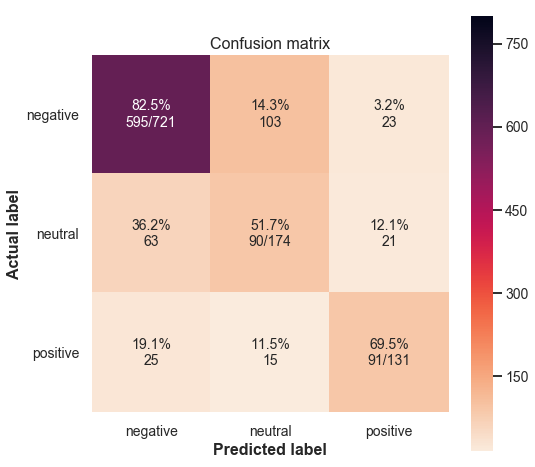

In [48]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [59]:
show_most_informative_features(pipe.named_steps['tfidfvectorizer'], pipe.named_steps['multinomialnb'])

	-8.6957	%             00		-5.8631	       usairways
	-8.6957	%         000lbs		-5.9569	              to
	-8.6957	%           00am		-6.1376	             the
	-8.6957	%            00p		-6.2229	             you
	-8.6957	%           00pm		-6.2603	              my
	-8.6957	%           0185		-6.2968	             and
	-8.6957	%           01pm		-6.3559	          flight
	-8.6957	%           0400		-6.3632	              on
	-8.6957	%     04sdytt7zd		-6.3827	              is
	-8.6957	%           0736		-6.5528	             for


### Other configurations

CountVectorizer, 90% threshold, binary, near miss undersampler

Accuracy:  0.38693957115009747 

              precision    recall  f1-score   support

    negative   0.820789  0.317614  0.458000       721
     neutral   0.241758  0.379310  0.295302       174
    positive   0.215190  0.778626  0.337190       131

   micro avg   0.386940  0.386940  0.386940      1026
   macro avg   0.425912  0.491850  0.363497      1026
weighted avg   0.645267  0.386940  0.414983      1026



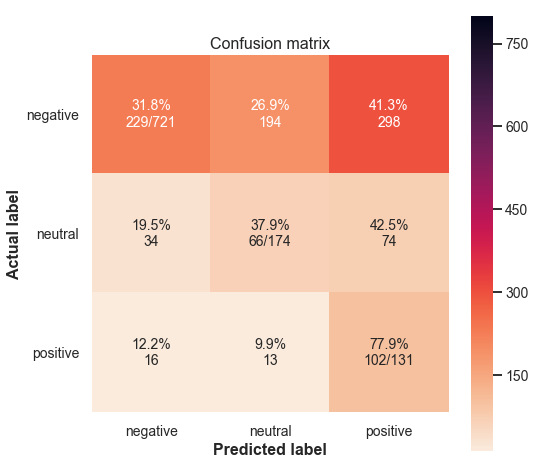

In [37]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, near miss undersampler

Accuracy:  0.3664717348927875 

              precision    recall  f1-score   support

    negative   0.812500  0.288488  0.425793       721
     neutral   0.252874  0.379310  0.303448       174
    positive   0.200393  0.778626  0.318750       131

   micro avg   0.366472  0.366472  0.366472      1026
   macro avg   0.421922  0.482142  0.349331      1026
weighted avg   0.639439  0.366472  0.391377      1026



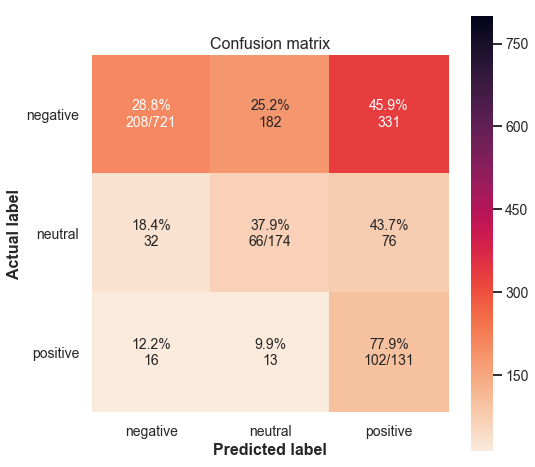

In [38]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary, near miss undersampler

Accuracy:  0.6432748538011696 

              precision    recall  f1-score   support

    negative   0.845361  0.682386  0.755180       721
     neutral   0.321429  0.465517  0.380282       174
    positive   0.453125  0.664122  0.538700       131

   micro avg   0.643275  0.643275  0.643275      1026
   macro avg   0.539971  0.604008  0.558054      1026
weighted avg   0.706426  0.643275  0.663961      1026



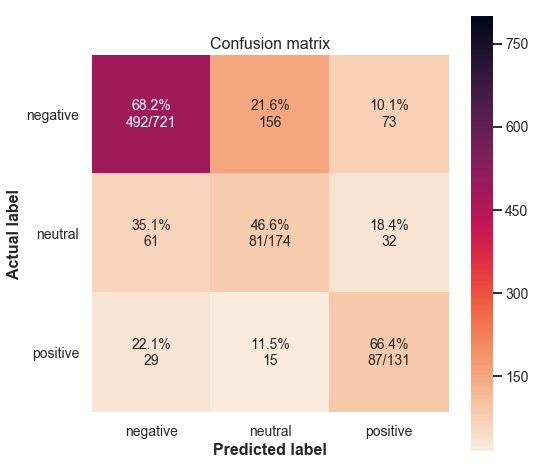

In [39]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, near miss undersampler

Accuracy:  0.6413255360623782 

              precision    recall  f1-score   support

    negative   0.836425  0.687933  0.754947       721
     neutral   0.312757  0.436782  0.364508       174
    positive   0.452632  0.656489  0.535826       131

   micro avg   0.641326  0.641326  0.641326      1026
   macro avg   0.533938  0.593735  0.551760      1026
weighted avg   0.698613  0.641326  0.660755      1026



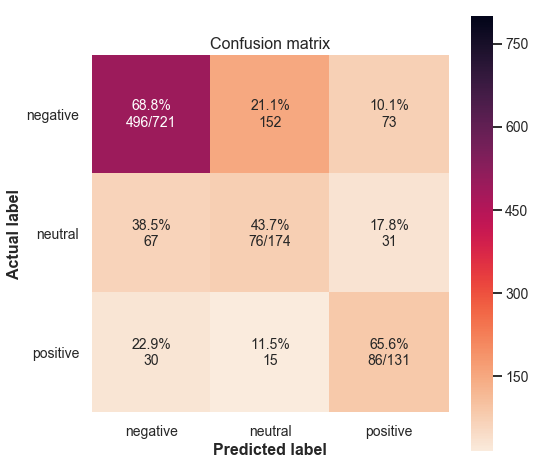

In [40]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

## <div style='background-color: #4D776B; color: #fcfcfc; padding: 0.6em;'>Best configuration</div>
CountVectorizer, 90% threshold, random undersampler

Accuracy:  0.702729044834308 

              precision    recall  f1-score   support

    negative   0.836232  0.800277  0.817860       721
     neutral   0.394737  0.344828  0.368098       174
    positive   0.456522  0.641221  0.533333       131

   micro avg   0.702729  0.702729  0.702729      1026
   macro avg   0.562497  0.595442  0.573097      1026
weighted avg   0.712877  0.702729  0.705256      1026



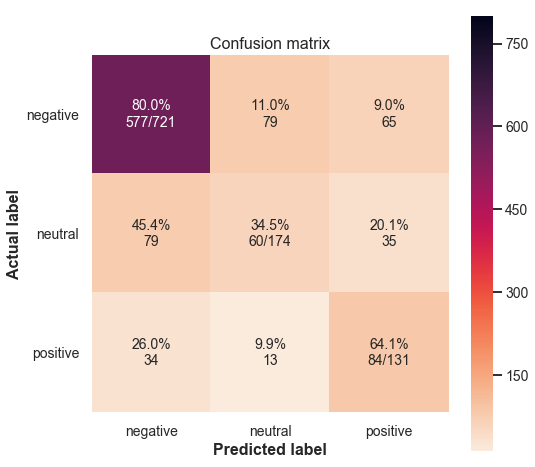

In [41]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, binary, random undersampler

Accuracy:  0.7066276803118908 

              precision    recall  f1-score   support

    negative   0.833572  0.805825  0.819464       721
     neutral   0.398649  0.339080  0.366460       174
    positive   0.469613  0.648855  0.544872       131

   micro avg   0.706628  0.706628  0.706628      1026
   macro avg   0.567278  0.597920  0.576932      1026
weighted avg   0.713343  0.706628  0.707579      1026



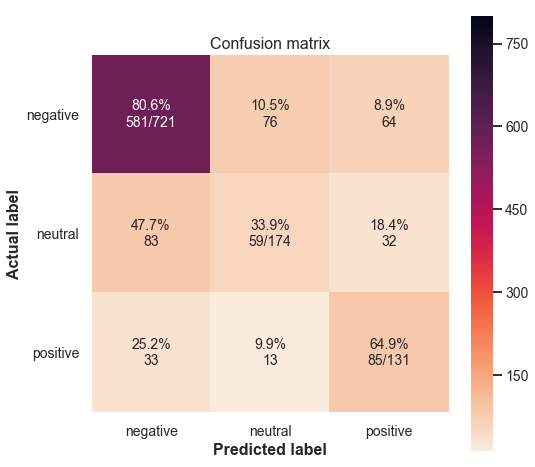

In [42]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, random undersampler

Accuracy:  0.6617933723196882 

              precision    recall  f1-score   support

    negative   0.833333  0.721221  0.773234       721
     neutral   0.336493  0.408046  0.368831       174
    positive   0.460733  0.671756  0.546584       131

   micro avg   0.661793  0.661793  0.661793      1026
   macro avg   0.543520  0.600341  0.562883      1026
weighted avg   0.701500  0.661793  0.675712      1026



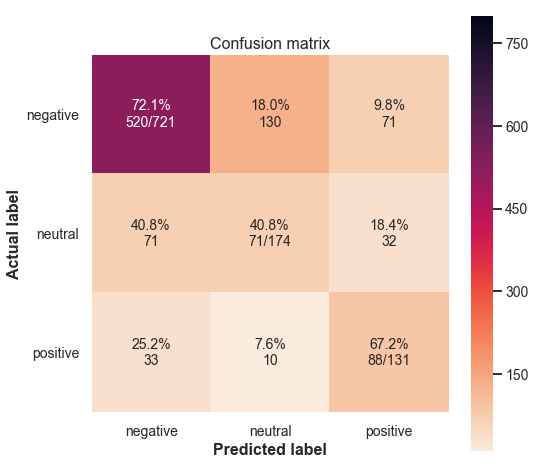

In [43]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary, random undersampler

Accuracy:  0.6432748538011696 

              precision    recall  f1-score   support

    negative   0.844068  0.690707  0.759725       721
     neutral   0.305785  0.425287  0.355769       174
    positive   0.453608  0.671756  0.541538       131

   micro avg   0.643275  0.643275  0.643275      1026
   macro avg   0.534487  0.595917  0.552344      1026
weighted avg   0.702926  0.643275  0.663360      1026



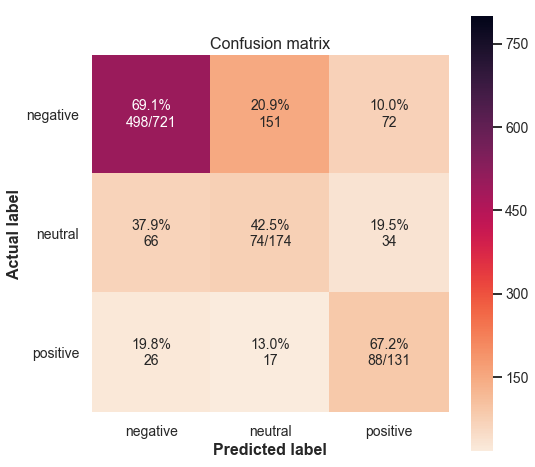

In [44]:
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))


********
# Program Writeup

...


********
## remove this afterwards!

### Data

You may follow the procedure done in the Python notebook if you're not sure what to do.

Study the data and understand what you have before moving to techniques.

The dataset to be used is a smaller version and only contains the sentiment (positive, neutral, negative), the airline in question (Virgin America and US Airways), and the text from the tweet.

There are 3,462 tweets in total. Its up to you how you understand the corpus and how its structure might affect the eventual learning model.


### Pre-process + Feature Extraction

Use at least 3 different feature extraction techniques out of, but not limited to, the following:
1. Term counts
2. Term frequency
3. Term frequency inverse document frequency
4. POS tags
5. Word sense counts
6. Word sense frequency
7. Sentiment-related features

You're expected to test out different parameters (e.g. # of POS tags, min/max document frequency) for each. It would be nice to report these, but you may stick with the best parameters based on experiments.
You may or may not perform pre-processing / cleaning, but you must talk about the effects of processing the data or leaving it raw.
1. Can preprocessing help in the boasting the accuracy?
2. Is the way you're tokenizing affecting the output?
3. Look at things before the learning bit and craft features that might contain loads of information for the classifier.


### Machine Learning

Limit yourselves to Naive Bayes. You are free to use other ML algorithms, but kindly just use one and focus on the effect of the techniques.
Kindly measure accuracy and F1 score (F-measure) for each model for comparison.
For simplicity, you can just do a single train and test split (like how the Python notebook shows).

There is a lot of room for you to do your thing here, but again, you are to focus on experimenting with different data pre-processing techniques and feature extraction methods. Don't overdo it and just focus on complying with the specs of the assignment. If you want to experiment with more, feel free to do so. :)

Please also use tools, like those from ScikitLearn or NLTK. Don't stress yourselves out doing too much. Search for implementations of the techniques.

You are also to create a write-up. Write all your observations, queries, comments, violent reactions, whatever. Which features did best/worst? Does it make sense that the best/worst features performed in such a manner? Was the dataset even good in the first place? The write-up has heavier weight than the program, so despite the program, focus on experimentation and note everything down.